## AUGMENT THE TRAIN DATA

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


In [13]:
datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest') #the strategy used for filling in newly created pixels

pigna_route = 'data/train/1_pigna/'
img = load_img(pigna_route+'pigna00003.png')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='pigna', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

labels = [['pigna'], ['pigna2'], ['noimporta'], ['buono'], ['pray'], ['ok']]

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
 
# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

1. buono
2. noimporta
3. ok
4. pigna
5. pigna2
6. pray


## LEARNING

There are different ways to modulate entropic capacity. The main one is the choice of the number of parameters in your model, i.e. the number of layers and the size of each layer. Another way is the use of weight regularization, such as L1 or L2 regularization, which consists in forcing model weights to taker smaller values.

In our case we will use a very small convnet with few layers and few filters per layer, alongside data augmentation and dropout. Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in your data).

The code snippet below is our first model, a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers.

## Model from scratch

In [2]:
# dimensions of our images.
img_width, img_height = 160, 160

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 59 #2000
nb_validation_samples = 6 #800
epochs = 50 #50
batch_size = 4 #16
input_shape = (img_width, img_height, 3) #Color images

#MODEL
def build_model():
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # the model so far outputs 3D feature maps (height, width, features)
    
    #On top of it we stick two fully-connected layers.
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6))
    model.add(Activation('softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam', #other optimizer: 'adam'
                  metrics=['accuracy'])
    
    return model

Let's prepare our data. We will use .flow_from_directory() to generate batches of image data (and their labels) directly from our jpgs in their respective folders.

In [3]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.02,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(img_width, img_height),  # all images will be resized to 150x150
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='sparse')  #1D numpy array of integer labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='sparse') #1D numpy array of integer labels


Found 299 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


In [4]:
model = build_model()

model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

model.save_weights('first_try.h5')  # always save your weights after training or during training


Epoch 1/50
14/14 [==============================] - 4s 297ms/step - loss: 1.9957 - acc: 0.1786 - val_loss: 1.6988 - val_acc: 0.0000e+00
Epoch 2/50
14/14 [==============================] - 3s 185ms/step - loss: 1.7842 - acc: 0.2143 - val_loss: 1.6813 - val_acc: 0.5000
Epoch 3/50
14/14 [==============================] - 3s 194ms/step - loss: 1.7251 - acc: 0.2143 - val_loss: 1.7025 - val_acc: 0.0000e+00
Epoch 4/50
14/14 [==============================] - 3s 210ms/step - loss: 1.6886 - acc: 0.1786 - val_loss: 1.6270 - val_acc: 0.2500
Epoch 5/50
14/14 [==============================] - 3s 203ms/step - loss: 1.7275 - acc: 0.1250 - val_loss: 1.6572 - val_acc: 0.2500
Epoch 6/50
14/14 [==============================] - 3s 224ms/step - loss: 1.7229 - acc: 0.2793 - val_loss: 1.8192 - val_acc: 0.0000e+00
Epoch 7/50
14/14 [==============================] - 3s 215ms/step - loss: 1.6739 - acc: 0.1429 - val_loss: 1.6033 - val_acc: 0.5000
Epoch 8/50
14/14 [==============================] - 3s 234ms/ste

## Predict

In [5]:
import cv2
from skimage import transform #Preprocess the frames
from skimage.color import rgb2gray #To gray the frames
import numpy as np

def preprocess_image(image_uri):

    # load the image
    image = cv2.imread(image_uri)
    #image = rgb2gray(image)

    # pre-process the image for classification
    image = transform.resize(image, [160, 160])
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    return image


class Predictor:
    def __init__(self, model_name):
        print("[INFO] loading network...")
        self.model = build_model()
        self.weights = self.model.load_weights(model_name)
    
    def predict_image(self, image_uri):
        # load the trained convolutional neural network
        image = preprocess_image(image_uri)

        # classify the input image then find the indexes of the two class
        # labels with the *largest* probability
        proba = self.model.predict(image)[0]
        idxs = np.argsort(proba)
        print("[INFO] classifying image...",proba, idxs)

        return np.argmax(proba)
        
predictor = Predictor("first_try.h5")   
predictor.predict_image("data/validation/2/archivo00002.png")

[INFO] loading network...


/Users/juancho/anaconda3/envs/isproject/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/juancho/anaconda3/envs/isproject/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


[INFO] classifying image... [0.14653234 0.21709365 0.18123135 0.27067018 0.18311752 0.00135498] [5 0 2 4 1 3]


3

In [9]:
predictor.predict_image("data/validation/3/archivo00002.png")

[INFO] classifying image... [0.14652734 0.21709535 0.1812321  0.27068996 0.18310112 0.00135411] [5 0 2 4 1 3]


3

### Edge detection (not used)

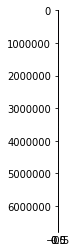

In [33]:
import cv2
import sys
import matplotlib.pyplot as plt

def edge_detection(image_uri):
    # The first argument is the image
    image = cv2.imread(image_uri)
    image_resized = transform.resize(image, [150, 150])

    #convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #blur it
    blurred_image = cv2.GaussianBlur(gray_image, (7,7), 0)
    #Edges
    canny = cv2.Canny(blurred_image, 10, 30)
    canny = transform.resize(canny, [180, 180])

    canny2 = cv2.Canny(blurred_image, 20, 60)
    canny2 = transform.resize(canny2, [180, 180])
    
    return image_resized, canny, canny2

img, canny, canny2 = edge_detection("data/validation/5/archivo00002.png")
#plt.imshow(img)
#plt.imshow(canny)
#plt.imshow(canny2)

### Hog features

In [61]:
from skimage.feature import hog

def hog_features(image_uri):
    ppc = 64
    hog_images = []
    hog_features = []

    image = cv2.imread(image_uri)
    image = transform.resize(image, [160, 160])
    image = rgb2gray(image)

    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),
                       cells_per_block=(4, 4),block_norm='L2',visualise=True)

    hog_images.append(hog_image)
    hog_features.append(fd)
    return hog_images, hog_features
    

hi, hf= hog_features("data/validation/5/archivo00002.png")
plt.imshow(hi[0])


/Users/juancho/anaconda3/envs/isproject/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/juancho/anaconda3/envs/isproject/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


ValueError: negative dimensions are not allowed

## Video frames

In [27]:
import cv2

vidcap = cv2.VideoCapture('data/videos/video1.mp4')
success,image = vidcap.read()
count = 0
success = True
image_count = 1
while success:
    if count%8==0:
        cv2.imwrite("data/videos/1/frame%d.jpg" % image_count, image) # save frame as JPEG file
        image_count += 1
        #print('Read a new frame: ', success)
    success,image = vidcap.read()    
    count += 1

## Classify the frames of the video

In [28]:
predicted = []
for i in range(1,image_count):
    predicted.append(predictor.predict_image("data/videos/1/frame%d.jpg" % i))

print(len(predicted))
print(predicted)

[INFO] classifying image... [0.17341092 0.1691308  0.16295822 0.17300425 0.15944482 0.16205095] [4 5 2 1 3 0]
[INFO] classifying image... [0.17341037 0.16913156 0.16295828 0.17300388 0.15944485 0.16205104] [4 5 2 1 3 0]
[INFO] classifying image... [0.1734103  0.16913094 0.16295815 0.1730043  0.15944521 0.16205111] [4 5 2 1 3 0]
[INFO] classifying image... [0.17341048 0.16913103 0.16295819 0.17300434 0.15944508 0.16205096] [4 5 2 1 3 0]
[INFO] classifying image... [0.17341073 0.16913137 0.16295812 0.17300408 0.15944475 0.16205098] [4 5 2 1 3 0]
[INFO] classifying image... [0.17341027 0.16913114 0.1629581  0.17300412 0.15944512 0.16205123] [4 5 2 1 3 0]
[INFO] classifying image... [0.17340048 0.16914923 0.16296518 0.17300913 0.15943672 0.16203932] [4 5 2 1 3 0]
[INFO] classifying image... [0.1733996  0.16914801 0.16296227 0.17300609 0.1594394  0.16204457] [4 5 2 1 3 0]
[INFO] classifying image... [0.173401   0.1691459  0.1629611  0.1730066  0.15944007 0.1620453 ] [4 5 2 1 3 0]
[INFO] cla

In [10]:
felicidad_tristeza = 0
calma_desesperacion = 0
agrado_desprecio = 0
euforia_enfado = 0

for i in predicted:
    if i == 0:
        felicidad_tristeza += 1
        calma_desesperacion += 1
        agrado_desprecio += 1
        euforia_enfado += 1
    if i == 1:
        felicidad_tristeza += 1
        calma_desesperacion += 3
        agrado_desprecio += 2
        euforia_enfado += 2
    if i == 2:
        felicidad_tristeza += 1
        calma_desesperacion += 3
        agrado_desprecio += 4
        euforia_enfado += 3
    if i == 3:
        felicidad_tristeza -= 4
        calma_desesperacion -= 3
        agrado_desprecio -= 3
        euforia_enfado -= 1
    if i == 4:
        felicidad_tristeza += 3
        calma_desesperacion += 5
        agrado_desprecio += 2
        euforia_enfado += 1
    if i == 5:
        felicidad_tristeza -= 4
        calma_desesperacion -= 2
        agrado_desprecio -= 5
        euforia_enfado -= 4

print(felicidad_tristeza)
print(calma_desesperacion)
print(agrado_desprecio)
print(euforia_enfado)

26
78
104
78


## Load pretrained model

In [10]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNetV2
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [14]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 160, 160
train_data_dir = "data/train"
validation_data_dir = "data/validation"
nb_train_samples = 59
nb_validation_samples = 6
batch_size = 4
epochs = 100

#model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

model = MobileNetV2(weights='imagenet',include_top=False,input_shape = (160, 160, 3)) 

#model = applications.resnet50.ResNet50(weights= "imagenet", include_top=False, input_shape= (img_height,img_width,3))

In [15]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
#for layer in model.layers[:4]:
#    layer.trainable = False
#Adding custom Layers 
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation='relu')(x) 
x = Dense(128, activation='relu')(x) 
x = Dropout(0.5)(x)
predictions = Dense(5, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.0005, momentum=0.9), 
                    metrics=["accuracy"])

# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3,
    rotation_range=30)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3,
    rotation_range=30)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle=True,
    #color_mode='grayscale',
    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_height, img_width),
    #color_mode='grayscale',
    shuffle=True,
    class_mode = "categorical")


/Users/juancho/anaconda3/envs/isproject/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Found 299 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


In [16]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=1, mode='auto')


# Train the model 
model_final.fit_generator(
    train_generator,
    samples_per_epoch = nb_train_samples,
    epochs = epochs,
    validation_data = validation_generator,
    nb_val_samples = nb_validation_samples,
    callbacks = [checkpoint, early])

model_final.save_weights('pretrained-resnet-3graybatches.h5')

/Users/juancho/anaconda3/envs/isproject/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/Users/juancho/anaconda3/envs/isproject/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=100, validation_data=<keras_pre..., callbacks=[<keras.ca..., steps_per_epoch=14, validation_steps=6)`
  del sys.path[0]


Epoch 1/100
14/14 [==============================] - 33s 2s/step - loss: 1.6564 - acc: 0.2321 - val_loss: 1.6839 - val_acc: 0.1556

Epoch 00001: val_acc improved from -inf to 0.15556, saving model to vgg16_1.h5
Epoch 2/100
14/14 [==============================] - 22s 2s/step - loss: 1.7355 - acc: 0.1607 - val_loss: 1.6276 - val_acc: 0.2222

Epoch 00002: val_acc improved from 0.15556 to 0.22222, saving model to vgg16_1.h5
Epoch 3/100
14/14 [==============================] - 22s 2s/step - loss: 1.6569 - acc: 0.2500 - val_loss: 1.6070 - val_acc: 0.2222

Epoch 00003: val_acc did not improve from 0.22222
Epoch 4/100
14/14 [==============================] - 23s 2s/step - loss: 1.7011 - acc: 0.1786 - val_loss: 1.6215 - val_acc: 0.2000

Epoch 00004: val_acc did not improve from 0.22222
Epoch 5/100
14/14 [==============================] - 23s 2s/step - loss: 1.6861 - acc: 0.1964 - val_loss: 1.5889 - val_acc: 0.3000

Epoch 00005: val_acc improved from 0.22222 to 0.30000, saving model to vgg16_1.

In [17]:
import cv2
from skimage import transform #Preprocess the frames
from skimage.color import rgb2gray #To gray the frames
import numpy as np

def preprocess_image(image_uri):

    # load the image
    image = cv2.imread(image_uri)
    #image = rgb2gray(image)

    # pre-process the image for classification
    image = transform.resize(image, [160, 160])
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    return image


class Predictor:
    def __init__(self, model_name):
        print("[INFO] loading network...")
        self.model = model_final
        self.weights = self.model.load_weights(model_name)
    
    def predict_image(self, image_uri):
        # load the trained convolutional neural network
        image = preprocess_image(image_uri)

        # classify the input image then find the indexes of the two class
        # labels with the *largest* probability
        proba = self.model.predict(image)[0]
        idxs = np.argsort(proba)
        print("[INFO] classifying image...",proba, idxs)

        return np.argmax(proba)
        
predictor = Predictor("pretrained-resnet-3batches.h5")

[INFO] loading network...


In [20]:
for i in range(1,6):
      print(predictor.predict_image("data/validation/%d/archivo00001.png" %i))

[INFO] classifying image... [0.13713612 0.21424581 0.24504414 0.22890255 0.17467143] [0 4 1 3 2]
2
[INFO] classifying image... [0.13671023 0.2141461  0.2448059  0.22915694 0.17518082] [0 4 1 3 2]
2
[INFO] classifying image... [0.13650383 0.21380776 0.24543701 0.22965024 0.1746012 ] [0 4 1 3 2]
2
[INFO] classifying image... [0.13783002 0.2136024  0.24518102 0.22858071 0.1748058 ] [0 4 1 3 2]
2
[INFO] classifying image... [0.13668552 0.21521641 0.24502823 0.22876182 0.17430812] [0 4 1 3 2]
2


In [89]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 25
nb_validation_samples = 5
epochs = 50
batch_size = 5


def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples)
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples)

    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

def build_model2():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    print(train_data.shape[1:])
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    
    return model

    
def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    train_labels = np.array([[1,0,0,0,0]] * 25 + [[0,1,0,0,0]] * 25 +
                           [[0,0,1,0,0]] * 25 + [[0,0,0,1,0]] * 25 + [[0,0,0,0,1]] * 25
                           )

    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array([[1,0,0,0,0]] * 5 + [[0,1,0,0,0]] * 5 +
                               [[0,0,1,0,0]] * 5 + [[0,0,0,1,0]] * 5 + [[0,0,0,0,1]] * 5
                                )

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    print(train_data.shape[1:])
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    
    model.save_weights(top_model_weights_path)
    

In [ ]:
save_bottlebeck_features()
train_top_model()

In [63]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

In [82]:
from tensorflow.python.keras.layers import Lambda
from tensorflow.python.keras import backend as K


# path to the model weights files.
weights_path = '../keras/examples/vgg16_weights.h5'
top_model_weights_path = 'fc_model.h5'
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 25
nb_validation_samples = 5
epochs = 20
batch_size = 5


model = applications.VGG16(weights='imagenet',include_top= False,input_shape=(150,150,3))
#Get the last but one layer/tensor from the old model
last_layer = model.layers[-2].output

#Define the new layer/tensor for the new model
new_model = Sequential()(last_layer)
new_model = Flatten()(new_model)
new_model = Dense(256, activation='relu')(new_model)
new_model = Dropout(0.5)(new_model)
new_model = Dense(5, activation='softmax')(new_model)

#Create the new model, with the old models input and the new_model tensor as the output
new_model = Model(model.input, new_model, name='Finetuned_VGG16')

#Set all layers,except the last one to not trainable
for layer in new_model.layers[:-1]: 
    layer.trainable=False


#now train with the new outputs (cats and dogs!)



# build the VGG16 network
#model = applications.VGG16(weights='imagenet', include_top=False, input_shape = (150, 150, 3))
#print('Model loaded.')

# build a classifier model to put on top of the convolutional model
#top_model = Sequential()
#top_model.add(Flatten(input_shape=model.output_shape[1:]))
#top_model.add(Dense(256, activation='relu'))
#top_model.add(Dropout(0.5))
#top_model.add(Dense(5, activation='softmax'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
#top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
#model.add(top_model)


#model = Model(input = model.input, output=top_model)

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

# fine-tune the model
model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)


Found 125 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


/Users/juancho/anaconda3/envs/isproject/lib/python3.6/site-packages/ipykernel_launcher.py:102: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/Users/juancho/anaconda3/envs/isproject/lib/python3.6/site-packages/ipykernel_launcher.py:102: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=20, validation_data=<keras_pre..., steps_per_epoch=5, validation_steps=5)`


Epoch 1/20


ValueError: Error when checking target: expected block5_pool to have 4 dimensions, but got array with shape (5, 5)